# 1. Data Preprocessing

We will do some data cleaning in this part. The data is present in 'flight_weather_data.csv', which is the combined data of EWR, JFK, and LGA airports of New York, along with the corresponding weather data for those airports. 

Firstly, we will convert date into a numerical day value that ranges from 1 to 365. We will then drop some redundant columns.

In [69]:
import pandas as pd
import numpy as np
import os

cur_dir = os.getcwd()


df = pd.read_csv(cur_dir + '/../data/flight_weather_data.csv', low_memory=False)

In [70]:
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,date,Maximum,Minimum,Average,Departure,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,2013-01-01,41.0,27.0,34.0,-0.3,31.0,0.0,T,T,0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,2013-01-01,41.0,27.0,34.0,-2.1,31.0,0.0,T,0.0,0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,2013-01-01,41.0,27.0,34.0,-0.6,31.0,0.0,0.00,0.0,0
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,2013-01-01,41.0,27.0,34.0,-0.6,31.0,0.0,0.00,0.0,0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,2013-01-01,41.0,27.0,34.0,-2.1,31.0,0.0,T,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,...,2013-09-30,72.0,52.0,62.0,-1.3,3.0,0.0,0.00,0.0,0
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,...,2013-09-30,73.0,58.0,65.5,-0.2,0.0,1.0,0.00,0.0,0
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,...,2013-09-30,73.0,58.0,65.5,-0.2,0.0,1.0,0.00,0.0,0
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,...,2013-09-30,73.0,58.0,65.5,-0.2,0.0,1.0,0.00,0.0,0


In [71]:
def convert_date_to_days_in_365(df):
  # starting day of each month - 1
  month_start_day = {
    1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 
    7: 181, 8: 212, 9: 243, 10: 273, 11: 304, 12: 334
  }

  days_in_365 = [month_start_day[i] for i in df['month']] + df['day']

  return days_in_365

def convert_time_to_minute_of_the_day(df):
  hour = [str(i)[:-2] for i in df['sched_dep_time']]
  minute = [str(i)[-2:] for i in df['sched_dep_time']]

# Convert date to days in range 1 to 365
df['days_in_365'] = convert_date_to_days_in_365(df)

# Drop the 'dep_time' column since it is duplicate (We have scheduled time and delay time)
df.drop('dep_time', axis=1, inplace=True)

# Remove rows with missing values in 'dep_delay' column. These are the flights that got cancelled
df.dropna(subset=['dep_delay'], inplace=True)

# Apply the 'delay_class' classification to 'dep_delay' column
df['dep_delay']=['yes' if x > 10 else 'no' for x in df['dep_delay']]
df.rename(columns={'dep_delay': 'delay_class'}, inplace=True)


In [72]:
print(str(df[df['delay_class'] == 'no'].delay_class.count()) + " flights were not delayed")
print(str(df[df['delay_class'] == 'yes'].delay_class.count()) + " flights were delayed")

245687 flights were not delayed
82834 flights were delayed


Remove the 'T' (trace) values from 'Precipitation', 'New Snow', and 'Snow Depth' columns  
In meteorological terms, trace means that the rain/snow was too negligible to be recorded  

We add new binary columns for these to preserve information, since negligible rain could mean   
that the weather was cloudy, and that might affect the flight delay probability

In [73]:
def remove_trace(df):
    cols = ['Precipitation', 'New Snow', 'Snow Depth']

    for col in cols:
        df[col + ' Binary'] = ['yes' if i == 'T' or float(i) != 0 else 'no' for i in df[col]]
        df[col] = [0 if i == 'T' else i for i in df[col]]

    return df

df = remove_trace(df)

In [74]:
df


,year,month,day,dep_time,sched_dep_time,delay_class,arr_time,sched_arr_time,arr_delay,carrier,...,Departure,HDD,CDD,Precipitation,New Snow,Snow Depth,days_in_365,Precipitation Binary,New Snow Binary,Snow Depth Binary
0,2013,1,1,517.0,515,no,830.0,819,11.0,UA,...,-0.3,31.0,0.0,0,0,0,1,yes,yes,no
1,2013,1,1,533.0,529,no,850.0,830,20.0,UA,...,-2.1,31.0,0.0,0,0.0,0,1,yes,no,no
2,2013,1,1,542.0,540,no,923.0,850,33.0,AA,...,-0.6,31.0,0.0,0.00,0.0,0,1,no,no,no
3,2013,1,1,544.0,545,no,1004.0,1022,-18.0,B6,...,-0.6,31.0,0.0,0.00,0.0,0,1,no,no,no
4,2013,1,1,554.0,600,no,812.0,837,-25.0,DL,...,-2.1,31.0,0.0,0,0.0,0,1,yes,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336765,2013,9,30,2240.0,2245,no,2334.0,2351,-17.0,B6,...,-1.3,3.0,0.0,0.00,0.0,0,273,no,no,no
336766,2013,9,30,2240.0,2250,no,2347.0,7,-20.0,B6,...,-1.3,3.0,0.0,0.00,0.0,0,273,no,no,no
336767,2013,9,30,2241.0,2246,no,2345.0,1,-16.0,B6,...,-1.3,3.0,0.0,0.00,0.0,0,273,no,no,no
336768,2013,9,30,2307.0,2255,yes,2359.0,2358,1.0,B6,...,-1.3,3.0,0.0,0.00,0.0,0,273,no,no,no


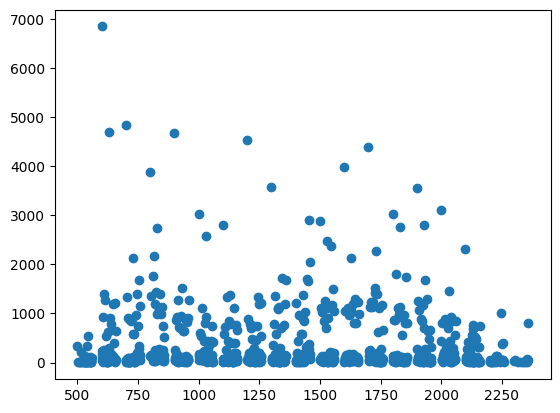

In [90]:
import matplotlib.pyplot as plt

from collections import Counter

x = Counter(df['sched_dep_time']).keys()
y = Counter(df['sched_dep_time']).values()

plt.scatter(x, y)